In [ ]:
import os, torch

# Where HF will cache stuff in general (models + datasets)
os.environ["HF_HOME"] = r"D:\hf_cache"
os.makedirs(os.environ["HF_HOME"], exist_ok=True)

# Where we keep THIS project’s model (base + fine-tuned)
MODEL_DIR = r"D:\hf_models\Finetuned_Sarcasm1"
os.makedirs(MODEL_DIR, exist_ok=True)

print("HF cache:", os.environ["HF_HOME"])
print("Model dir:", MODEL_DIR)

print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))


HF cache: D:\hf_cache
Model dir: D:\hf_models\Finetuned_Sarcasm1
CUDA available: True
GPU: NVIDIA GeForce RTX 4070 Laptop GPU


Downloading the Model

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

base_model_name = "roberta-base"

# Download from HF hub
tokenizer = AutoTokenizer.from_pretrained(base_model_name)
model = AutoModelForSequenceClassification.from_pretrained(
    base_model_name,
    num_labels=2
)

#Save to Folder
tokenizer.save_pretrained(MODEL_DIR)
model.save_pretrained(MODEL_DIR)

print("Base model downloaded and saved to:", MODEL_DIR)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Base model downloaded and saved to: D:\hf_models\Finetuned_Sarcasm1


Loading the Model




In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained(MODEL_DIR, local_files_only=True)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_DIR,
    local_files_only=True
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print("Loaded model from:", MODEL_DIR)


Loaded model from: D:\hf_models\Finetuned_Sarcasm1


In [ ]:
from datasets import load_dataset

dataset = load_dataset("AgamP/sarcasm-detection")
print(dataset)


Sarcasm_Headlines_Dataset.json: 0.00B [00:00, ?B/s]

Sarcasm_Headlines_Dataset_v2.json: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/55328 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['article_link', 'headline', 'is_sarcastic'],
        num_rows: 55328
    })
})


In [ ]:
print(dataset['train'][0])
print(dataset['train'].column_names)


{'article_link': 'https://www.huffingtonpost.com/entry/versace-black-code_us_5861fbefe4b0de3a08f600d5', 'headline': "former versace store clerk sues over secret 'black code' for minority shoppers", 'is_sarcastic': 0}
['article_link', 'headline', 'is_sarcastic']


In [ ]:
dataset = dataset.rename_column("headline", "text")
dataset = dataset.rename_column("is_sarcastic", "label")

# Remove unwanted column
dataset = dataset.remove_columns(["article_link"])


In [ ]:
print(dataset['train'][0])
print(dataset['train'].column_names)

{'text': "former versace store clerk sues over secret 'black code' for minority shoppers", 'label': 0}
['text', 'label']


In [ ]:
dataset = dataset['train'].train_test_split(
    test_size=0.3,
    seed=42
)

train_ds = dataset['train']
val_ds = dataset['test']


In [ ]:
from transformers import AutoTokenizer

def tokenize(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        padding="max_length",
        max_length=128
    )

train_ds = train_ds.map(tokenize, batched=True)
val_ds = val_ds.map(tokenize, batched=True)

train_ds = train_ds.remove_columns(["text"])
val_ds = val_ds.remove_columns(["text"])

train_ds = train_ds.with_format("torch")
val_ds = val_ds.with_format("torch")


Map:   0%|          | 0/38729 [00:00<?, ? examples/s]

Map:   0%|          | 0/16599 [00:00<?, ? examples/s]

In [ ]:
print(train_ds[0])
print(val_ds[0])

{'label': tensor(1), 'input_ids': tensor([    0, 19456,     6,  1354,  2081, 45320, 39691,  1258,    12,  3368,
         1579,    81,  3630,  2103,     2,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,  

In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer


training_args = TrainingArguments(
    output_dir="sarcasm_model",
    eval_strategy="epoch",
    logging_steps=50,
    save_strategy="epoch",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    weight_decay=0.01,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
)

trainer.train()


Epoch,Training Loss,Validation Loss
1,0.187600,0.171692
2,0.140100,0.141784
3,0.040500,0.172365


TrainOutput(global_step=7263, training_loss=0.13664647779253974, metrics={'train_runtime': 1275.8479, 'train_samples_per_second': 91.066, 'train_steps_per_second': 5.693, 'total_flos': 7642521047278080.0, 'train_loss': 0.13664647779253974, 'epoch': 3.0})

In [ ]:
MODEL_DIR = r"D:\hf_models\Finetuned_Sarcasm2"
trainer.save_model(MODEL_DIR)
tokenizer.save_pretrained(MODEL_DIR)

print("Fine-tuned model saved to:", MODEL_DIR)

Fine-tuned model saved to: D:\hf_models\Finetuned_Sarcasm2


In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_DIR, local_files_only=True)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_DIR,
    local_files_only=True
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print("Loaded model from:", MODEL_DIR)

Loaded model from: D:\hf_models\Finetuned_Sarcasm2


In [ ]:
from datasets import load_dataset
from torch.utils.data import DataLoader
import torch
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Load the HF dataset
raw_ds = load_dataset("AgamP/sarcasm-detection")

# Preprocessing
raw_ds = raw_ds.rename_column("headline", "text")
raw_ds = raw_ds.rename_column("is_sarcastic", "label")
raw_ds = raw_ds.remove_columns(["article_link"])

# Make our own train/test split from the HF train split
split_ds = raw_ds["train"].train_test_split(test_size=0.1, seed=42)
val_ds = split_ds["test"]

# Tokenize with finetuned model's tokenizer
def tokenize(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        padding="max_length",
        max_length=128
    )

val_ds = val_ds.map(tokenize, batched=True)

# Keep only tensors needed by the model
val_ds = val_ds.remove_columns(["text"])
val_ds = val_ds.rename_column("label", "labels")

val_ds.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "labels"]
)

val_loader = DataLoader(val_ds, batch_size=32)


Map:   0%|          | 0/5533 [00:00<?, ? examples/s]

In [ ]:
# Run evaluation with your finetuned model
model.eval()

all_logits = []
all_labels = []

with torch.no_grad():
    for batch in val_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        labels = batch["labels"]

        outputs = model(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"]
        )
        logits = outputs.logits

        all_logits.append(logits.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# Stack all batches
all_logits = np.concatenate(all_logits, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

y_pred = np.argmax(all_logits, axis=1)
y_true = all_labels

# Metrics
acc = accuracy_score(y_true, y_pred)
print(f"Validation Accuracy: {acc:.4f}")

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix (rows = true, cols = predicted):")
print(cm)

print("\nClassification Report:")
print(classification_report(
    y_true,
    y_pred,
    target_names=["not_sarcastic (0)", "sarcastic (1)"]
))

Validation Accuracy: 0.9711
Confusion Matrix (rows = true, cols = predicted):
[[2968   27]
 [ 133 2405]]

Classification Report:
                   precision    recall  f1-score   support

not_sarcastic (0)       0.96      0.99      0.97      2995
    sarcastic (1)       0.99      0.95      0.97      2538

         accuracy                           0.97      5533
        macro avg       0.97      0.97      0.97      5533
     weighted avg       0.97      0.97      0.97      5533



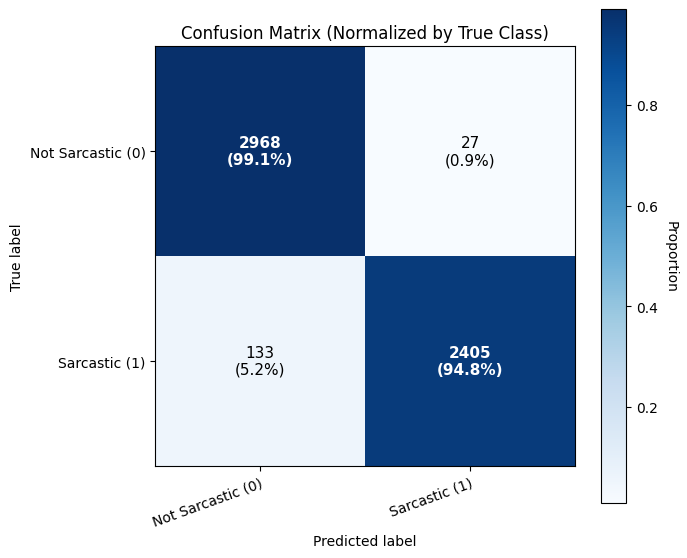

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# 2. Normalize by row (so each row sums to 1)
cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)

# 3. Class names (adjust if your label mapping is different)
class_names = ["Not Sarcastic (0)", "Sarcastic (1)"]

fig, ax = plt.subplots(figsize=(7, 6))

# 4. Show heatmap
im = ax.imshow(cm_norm, interpolation="nearest", cmap="Blues")
cbar = fig.colorbar(im, ax=ax)
cbar.ax.set_ylabel("Proportion", rotation=-90, va="bottom")

# 5. Tick labels
ax.set(
    xticks=np.arange(len(class_names)),
    yticks=np.arange(len(class_names)),
    xticklabels=class_names,
    yticklabels=class_names,
    ylabel="True label",
    xlabel="Predicted label",
    title="Confusion Matrix (Normalized by True Class)"
)

plt.setp(ax.get_xticklabels(), rotation=20, ha="right", rotation_mode="anchor")

# 6. Write both count and % inside each cell
fmt = ".1f"
thresh = cm_norm.max() / 2.0

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        count = cm[i, j]
        pct = cm_norm[i, j] * 100
        text = f"{count}\n({pct:{fmt}}%)"
        ax.text(
            j, i, text,
            ha="center", va="center",
            fontsize=11,
            fontweight="bold" if i == j else "normal",
            color="white" if cm_norm[i, j] > thresh else "black",
        )

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np

# Distribution of true labels
unique_true, counts_true = np.unique(y_true, return_counts=True)
print("True label distribution:")
for u, c in zip(unique_true, counts_true):
    print(f"Label {u}: {c}")

# Distribution of predicted labels
unique_pred, counts_pred = np.unique(y_pred, return_counts=True)
print("\nPredicted label distribution:")
for u, c in zip(unique_pred, counts_pred):
    print(f"Label {u}: {c}")


True label distribution:
Label 0: 2995
Label 1: 2538

Predicted label distribution:
Label 0: 3101
Label 1: 2432
